<a href="https://colab.research.google.com/github/jhyunwoo/siamese-new-letter-recognition/blob/main/MNIST_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **정보통신 수행평가 - Siamese Network를 이용한 '처음 보는 문자' 구별하기**

> 김연준, 전현우, 이여명, 홍준혁. 2023.5.29

# **PREREQUISITES**

### 필요 라이브러리 Import

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import plot_model

### MNIST 데이터셋 불러오기

In [ ]:
from keras.datasets import mnist
objects=mnist
(train_img,train_label),(test_img,test_label)=objects.load_data()

train_img = train_img.reshape(train_img.shape[0], 28, 28, 1)
test_img = test_img.reshape(test_img.shape[0], 28, 28, 1)

#normalization
train_img = train_img / 255.
test_img = test_img / 255.

11490434/11490434 [==============================] - 0s 0us/step


# **데이터 전처리, 확인과 관련된 함수**

### 학습에 쓰일 이미지 쌍 생성하는 함수

In [ ]:
 # create pairs on train and test sets
def create_pairs(x, y):
    pairs = []
    labels = []

    digit_indices = [np.where(y == i)[0] for i in range(10)] # 클래스가 i인 이미지가 몇 번 index에 있는지 인지 i=0~9에 대해 저장
    n = min([len(digit_indices[d]) for d in range(10)]) - 1 # n = (가장 적은 이미지 개수를 가진 클래스의 이미지 개수) - 1

    for d in range(10):
        for i in range(n): # 각 클래스에 있는 이미지 데이터를 중복 없이 최대한 사용하기 위한 loop
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]] #서로 같은 클래스에서 가져온 이미지 쌍

            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]] #서로 다른 클래스에서 가져온 이미지 쌍

            labels += [1, 0] # 첫 번째는 같은 클래스 쌍, 두 번째는 다른 클래스 쌍이므로 label도 1, 0 순으로 추가

    return np.array(pairs), np.array(labels).astype('float32')

In [ ]:
tr_pairs, tr_y = create_pairs(train_img, train_label)
ts_pairs, ts_y = create_pairs(test_img, test_label)

### 이미지 쌍 화면에 그리는 함수

In [ ]:
def show_image(image1, image2):
    plt.figure(figsize=(4, 2))
    plt.grid(False)

    plt.subplot(1,2,1)
    plt.imshow(image1)

    plt.subplot(1,2,2)
    plt.imshow(image2)

    plt.show()

<ipython-input-6-e430aa8662fc>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


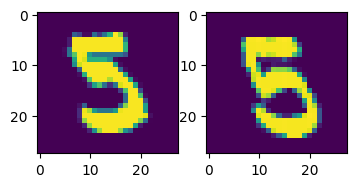

1.0


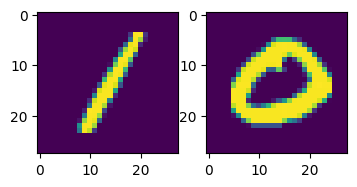

0.0


In [ ]:
even_pair = 10000
odd_pair = 3333
# show images at this index
show_image(ts_pairs[even_pair][0], ts_pairs[even_pair][1])
print(ts_y[even_pair])
show_image(ts_pairs[odd_pair][0], ts_pairs[odd_pair][1])
print(ts_y[odd_pair])

# **Siamese Network**

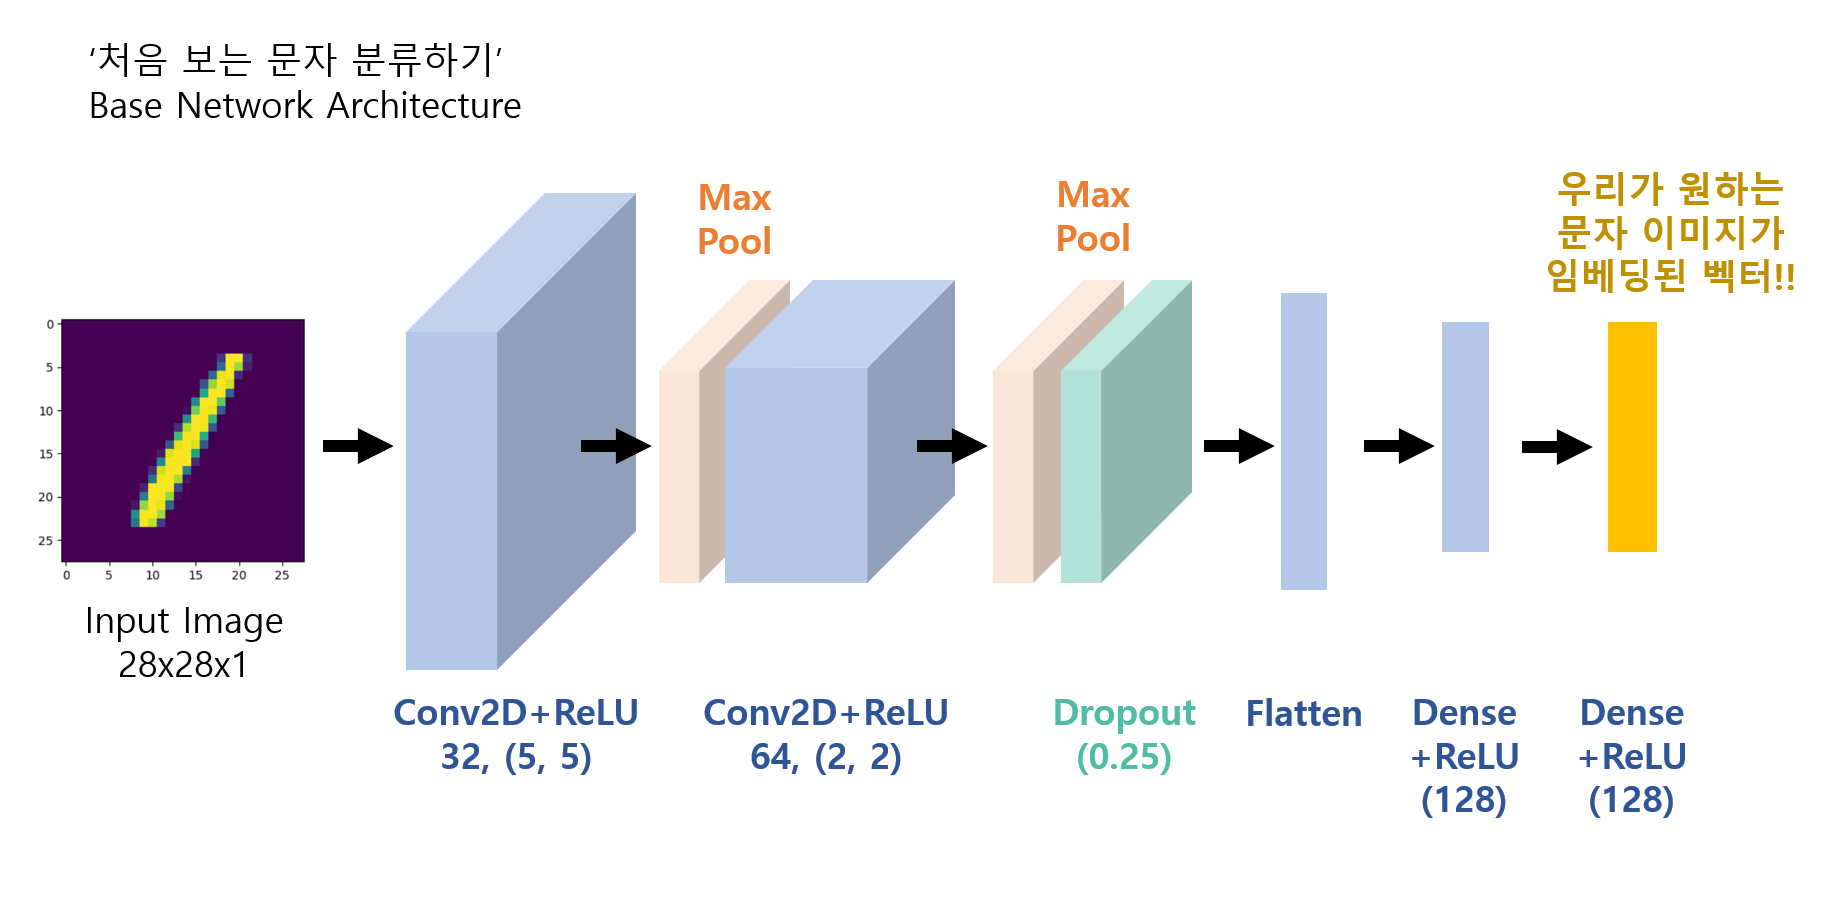

In [ ]:
# 전체 모델의 일부로써 학습할 네트워크
def base_network():
    input = Input(shape=(28, 28, 1), name='base_input')
    x = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='leaky_relu')(input)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='leaky_relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='leaky_relu')(x)
    x = Dense(128, activation='leaky_relu')(x)

    base_model = Model(inputs=input, outputs=x)

    return base_model

In [ ]:
# 두 벡터 간의 유클리드 거리 함수
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    dist = tf.math.sqrt(sum_square)
    return dist

# 유사도 점수 함수
def sim_score(vects):
    dist = euclidean_distance(vects)
    return 2*(tf.math.sigmoid(10*dist)) - 1.0


def sim_score_cosine(vects):
    x, y = vects
    x = tf.math.l2_normalize(x, axis=1)
    y = tf.math.l2_normalize(y, axis=1)
    result = tf.math.reduce_sum( tf.math.multiply(x,y), axis=1 )

    return result

In [ ]:
# base 네트워크 인스턴스 선언
base_model = base_network()
#plot_model(base_model, show_shapes=True, show_layer_names=True

#v1 = base_model(np.array([ts_pairs[odd_pair][0],ts_pairs[even_pair][0], ts_pairs[odd_pair][0]]))
#v2 = base_model(np.array([ts_pairs[odd_pair][1],ts_pairs[even_pair][1], ts_pairs[odd_pair][0]]))
#print(sim_score((v1, v2)))

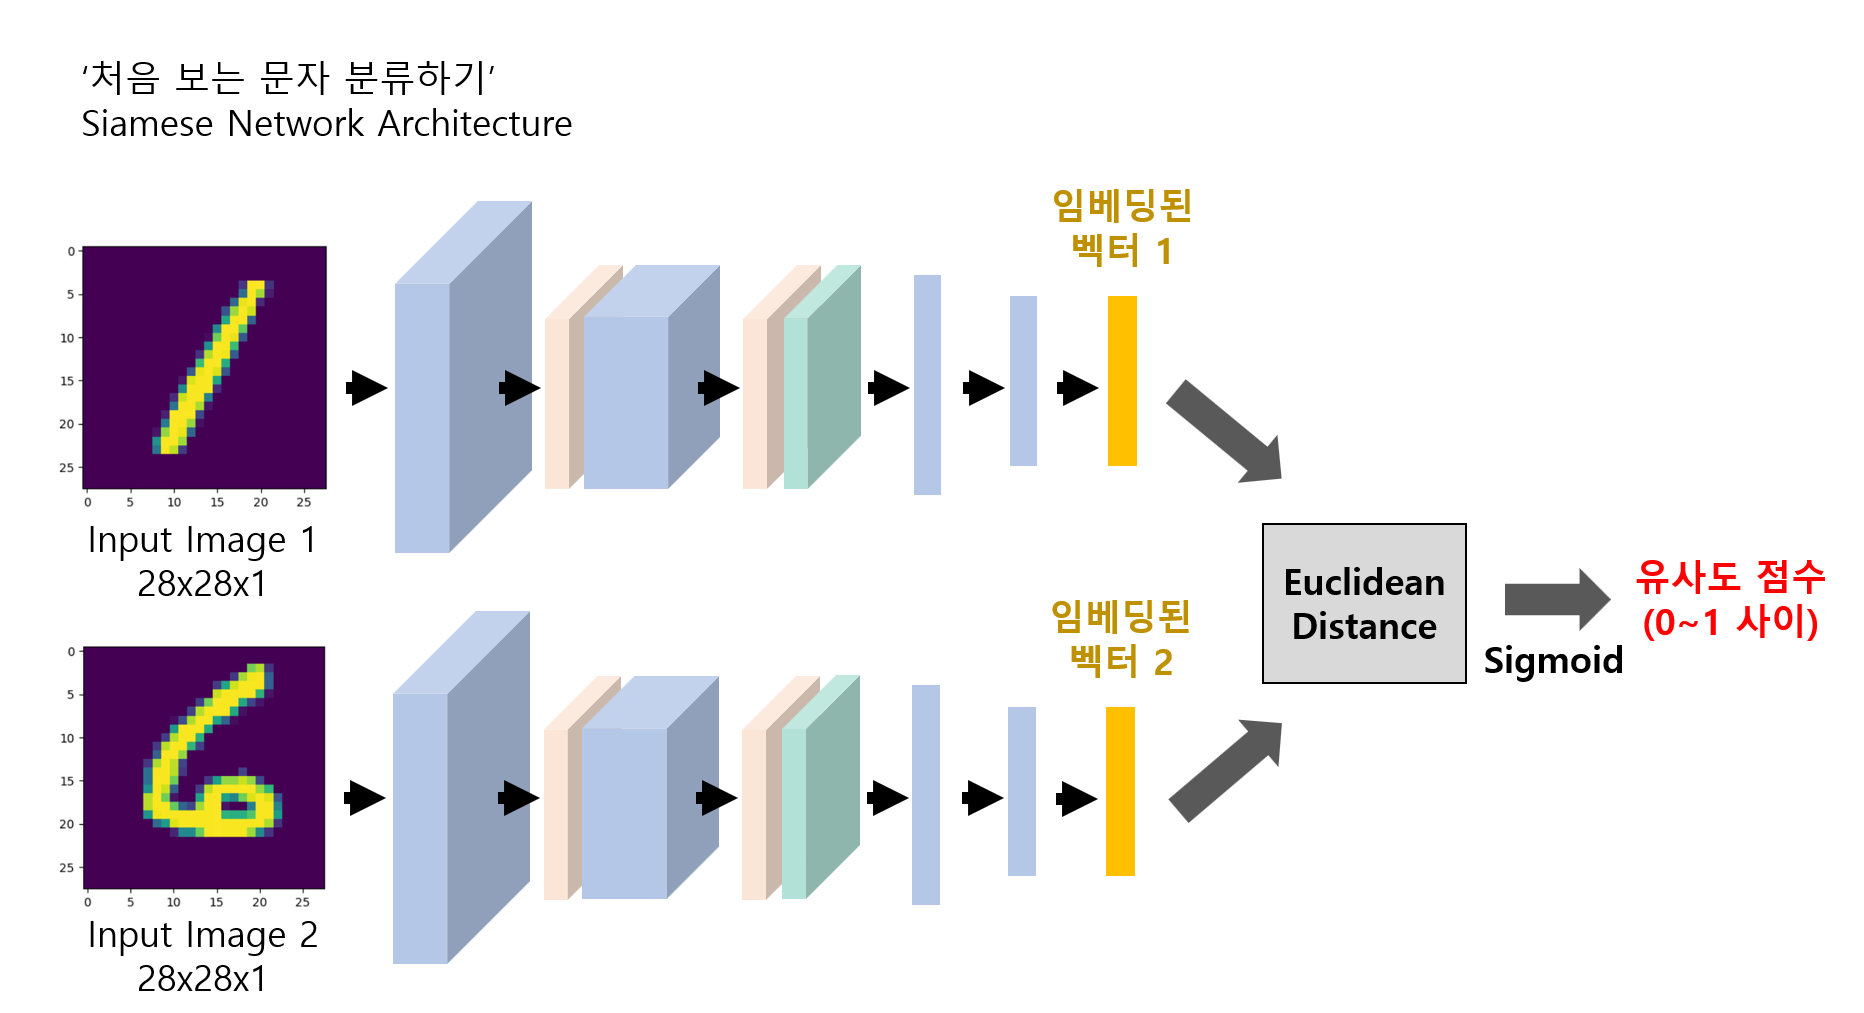


In [ ]:
input_a = Input(shape=(28,28,1), name='left_input')
vector_output_a = base_model(input_a)

input_b = Input(shape=(28,28,1), name='right_input')
vector_output_b = base_model(input_b)

output = Lambda(sim_score_cosine, name='output_layer')([vector_output_a, vector_output_b])

# 모델 인스턴스 선언
model = Model([input_a, input_b], output)
#plot_model(model, show_shapes=True, show_layer_names=True)

# **Loss 정의 & Training**

### Constrastive Loss 정의

In [ ]:
def contrastive_loss(y_true, y_pred):
  return tf.math.reduce_mean(tf.math.square(y_true - y_pred))

### Compile & Train

In [ ]:
model.compile(loss=contrastive_loss, optimizer='adam')

train_new = False

if train_new:
    history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y,
                    epochs=40, batch_size=256,
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))
    # 학습한 모델 저장
    model.save_weights('siamese1.h5')
else:
    # 학습된 모델 불러옴
    model.load_weights('siamese1(2023.6.2).h5')

# **학습한 모델 평가**

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() >= 0.5
    return np.mean(pred == y_true)

loss = model.evaluate([ts_pairs[:,0],ts_pairs[:,1]], ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

557/557 [==============================] - 1s 2ms/step
Loss = 0.004844909068197012, Train Accuracy = 0.9999815498154981 Test Accuracy = 0.9933221099887767


### Loss 변화 추이 Plot

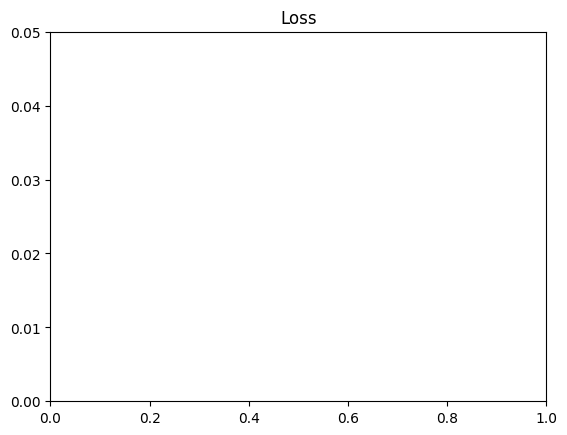

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()

try:
  plot_metrics(metric_name='loss', title="Loss", ylim=0.05)
except:
  pass

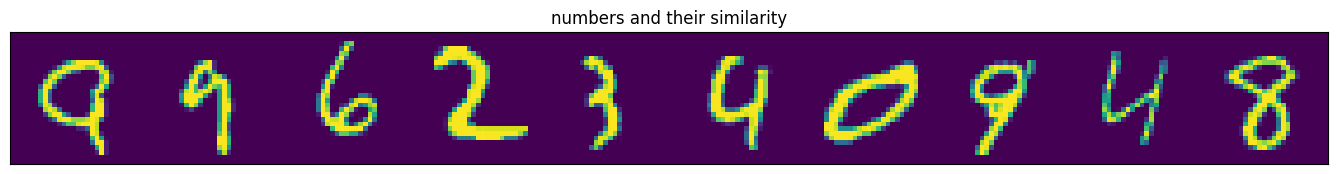

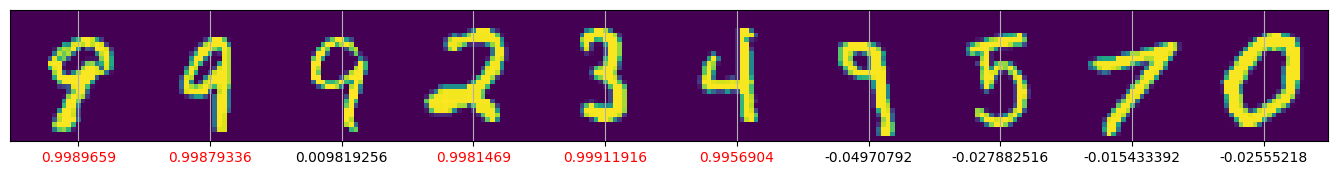

In [ ]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "numbers and their similarity", 10)


# **새로운 문자 인식**

(28, 28, 1)
홍준혁1과 홍준혁2의 유사도 0.91814256


<ipython-input-6-e430aa8662fc>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


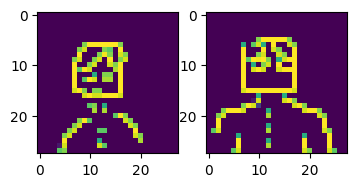

홍준혁1과 숫자 샘플의 유사도 0.054841343


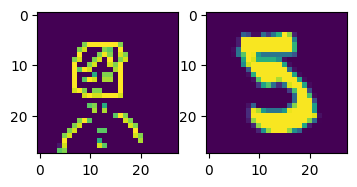

In [ ]:
print(np.shape(tr_pairs[0,0]))

import PIL.Image as pilimg

# Fetch image pixel data to numpy array
pic0 = np.array(pilimg.open("hjh0.png").convert('L'))
pic0 = np.invert(pic0)
pic0 = pic0.reshape(1,28,28,1)

pic1 = np.array(pilimg.open("hjh1.png").convert('L'))
pic1 = np.invert(pic1)
pic1 = pic1.reshape(1,28,28,1)

pic2 = np.array(pilimg.open("hjh5.png").convert('L'))
pic2 = np.invert(pic2)
pic2 = pic2.reshape(1,28,28,1)

pic3 = np.array(pilimg.open("hjh6.png").convert('L'))
pic3 = np.invert(pic3)
pic3 = pic3.reshape(1,28,28,1)

a = pic0
b = pic2

v1 = base_model(a)
v2 = base_model(b)
v3 = base_model(np.array([ts_pairs[10000,0]]))

print('홍준혁1과 홍준혁2의 유사도', sim_score_cosine((v1, v2)).numpy()[0])
show_image(a[0], b[0])
print('홍준혁1과 숫자 샘플의 유사도', sim_score_cosine((v1, v3)).numpy()[0])
show_image(a[0], ts_pairs[10000,0])